# Normalize L1C scenes radiometrically

Each EO-product should include a **pre-processing step** in the beginning for masking out clouds, radiometric corrections and in order to avoid unnecessary artefacts in the final product. One of the most basic pre-processing methods is a radiometric adjustment in order to obtain the Bottom-Of-Atmosphere reflectance.

In contrast to this absolute radiometric correction which is often done using Sen2cor, also a relative radiometric normalization can be done. This approach normalizes an image on a temporal basis by analyzing a time-series. As a result, influences of recorded reflectances such as the sun's azimuth angle, elevation and atmospheric conditions can be rectified to a certain extent.

Using the `EOLearn-Library` of Sentinel Hub simplifies this approach significantly. For an AOI and time interval of choice, Sentinel-2 data will be downloaded in form of an `EOPatch`. This `EOPatch` gets manipulated in a sequence of `EOTasks` chained in an `EOWorkflow`.

---

In this example the final workflow to radiometrically normalize Sentinel-2 scenes is a sequence of the following tasks:
1. Create an `EOPatch` by filling it with L1C data including every band
2. Add Sen2Cor's scene classification map
3. Validate pixels using Sen2Cor's scene classification map
4. Count number of valid observations per pixel using valid data mask
5. Calculate fraction of valid pixels
6. Mask the `EOPatch` with the Scene Classification Layer (SCL)
7. Select scenes with highest fraction of valid pixels as reference scenes
8. Create a composite of the reference scenes
9. Remove temporary EOPatch layers
10. Perform a histogram match


**Contributor:**  
_Johannes Schmid  
[GeoVille Information Systems GmbH](www.geoville.com)  
2018_  

## Load Modules

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Basic EOLearn libraries
from eolearn.core import EOTask, EOPatch, EOWorkflow, FeatureType, RemoveFeature

# We'll use Sentinel-2 imagery (Level 1C) provided through SentinelHub
# If you don't know what `Level 1C` means, don't worry. It doesn't matter.
from eolearn.io import S2L1CWCSInput, AddSen2CorClassificationFeature

# Import classes to perform radiometric normalisation
from eolearn.features import ReferenceScenes

# cloud detection
from eolearn.mask import AddValidDataMaskTask, MaskFeature

# Sentinel Hub
from sentinelhub import BBox, CRS, MimeType, CustomUrlParam

# Numpy for manipulating the rasters in form of arrays
import numpy as np

# For Plotting
import matplotlib.pyplot as plt

##### Check your eolearn library version (this script is based on version 0.3.3)

In [3]:
# import pkg_resources
# pkg_resources.get_distribution("eo-learn").version
from eolearn.features import __version__
__version__

'0.3.3'

## EOTask Classes and neccesary functions

In [4]:
class Compositing(EOTask):
    """
    Contributor: Johannes Schmid, GeoVille Information Systems GmbH, 2018
    Creates a composite of reference scenes.
    """
    def __init__(self, method, layer):
        """
        :param method: Different compositing methods can be chosen:
          - blue     (25th percentile of the blue band)
          - HOT      (Index using bands blue and red)
          - maxNDVI  (temporal maximum of NDVI)
          - maxNDWI  (temporal maximum of NDWI)
          - maxRatio (temporal maximum of a ratio using bands blue, NIR and SWIR)
        :type method: str
        :param layer: Name of the eopatch data layer. Needs to be of the FeatureType "DATA"
        :type layer: str
        """
        self.method = method
        self.layer = layer
        self.perc_no = 25
        self.ref_stack = None

    def index_by_percentile(self, quant):
        """Calculate percentile of numpy stack and return the index of the chosen pixel. """
        # valid (non NaN) observations along the first axis
        arr_tmp = np.array(self.ref_stack, copy=True)

        # no_obs = bn.allnan(arr_tmp["data"], axis=0)
        valid_obs = np.sum(np.isfinite(arr_tmp["data"]), axis=0)
        # replace NaN with maximum
        max_val = np.nanmax(arr_tmp["data"]) + 1
        arr_tmp["data"][np.isnan(arr_tmp["data"])] = max_val
        # sort - former NaNs will move to the end
        arr_tmp = np.sort(arr_tmp, kind="mergesort", order="data", axis=0)
        arr_tmp["data"] = np.where(arr_tmp["data"] == max_val, np.nan, arr_tmp["data"])

        # desired position as well as floor and ceiling of it
        k_arr = (valid_obs - 1) * (quant / 100.0)
        k_arr = np.where(k_arr < 0, 0, k_arr)
        f_arr = np.floor(k_arr + 0.5)
        f_arr = f_arr.astype(np.int)

        # get floor value of reference band and index band
        ind = f_arr.astype("int16")
        y_val = arr_tmp.shape[1]
        x_val = arr_tmp.shape[2]
        y_val, x_val = np.ogrid[0:y_val, 0:x_val]
        floor_val = arr_tmp[ind, y_val, x_val]

        idx = np.where(valid_obs == 0, 255, floor_val["ID"])

        quant_arr = floor_val["data"]

        del arr_tmp

        return quant_arr, idx, valid_obs

    def get_band(self, sce):
        success = False
        ref = None
        if self.method == "blue":
            ref = sce[:, :, 0].astype("float32")
            success = True
        elif self.method == "maxNDVI":
            nir = sce[:, :, 7].astype("float32")
            red = sce[:, :, 2].astype("float32")
            ref = (nir - red) / (nir + red)
            del nir, red
            success = True
        elif self.method == "HOT":
            blue = sce[:, :, 0].astype("float32")
            red = sce[:, :, 2].astype("float32")
            ref = blue - 0.5 * red - 800.
            del blue, red
            success = True
        elif self.method == "maxRatio":
            blue = sce[:, :, 0].astype("float32")
            nir = sce[:, :, 6].astype("float32")
            swir1 = sce[:, :, 8].astype("float32")
            ref = np.nanmax(np.array([nir, swir1]), axis=0) / blue
            del blue, nir, swir1
            success = True
        elif self.method == "maxNDWI":
            nir = sce[:, :, 6].astype("float32")
            swir1 = sce[:, :, 8].astype("float32")
            ref = (nir - swir1) / (nir + swir1)
            del nir, swir1
            success = True

        return success, ref

    def execute(self, eopatch):
        # Dictionary connecting sceneIDs and composite index number
        data_layers = eopatch.data[self.layer]
        scene_lookup = {}
        for j, dlayer in enumerate(data_layers):
            scene_lookup[j] = dlayer

        # Stack scenes with data and scene index number
        dims = (data_layers.shape[0], data_layers.shape[1], data_layers.shape[2])
        self.ref_stack = np.zeros(dims, dtype=[("data", "f4"), ("ID", "u1")])
        self.ref_stack["ID"] = 255

        # Reference bands
        for j, sce in enumerate(data_layers):  # for each scene/time

            # Read in bands depending on composite method
            success, ref = self.get_band(sce)
            if self.method not in ["blue", "maxNDVI", "HOT", "maxRatio", "maxNDWI"]:
                raise ValueError("{} is not a valid compositing method!".format(self.method))
            if not success:
                raise NameError("Bands for composite method {} were not found!".format(self.method))

            # Write data to stack
            self.ref_stack["data"][j] = ref
            self.ref_stack["ID"][j] = j
            del ref

        # Calculate composite index (which scene is used for the composite per pixel)
        valid_obs = None
        index = None
        if self.method == "blue":
            index, valid_obs = self.index_by_percentile(self.perc_no)[1:3]
        elif self.method == "maxNDVI":
            median = np.nanmedian(self.ref_stack["data"], axis=0)
            index_max, valid_obs = self.index_by_percentile(100)[1:3]
            index_min, valid_obs = self.index_by_percentile(0)[1:3]
            index = np.where(median < -0.05, index_min, index_max)
        elif self.method == "HOT":
            index, valid_obs = self.index_by_percentile(25)[1:3]
        elif self.method == "maxRatio":
            index, valid_obs = self.index_by_percentile(100)[1:3]
        elif self.method == "maxNDWI":
            index, valid_obs = self.index_by_percentile(100)[1:3]

        try:
            del self.ref_stack, valid_obs
            index_scenes = [scene_lookup[idx] for idx in np.unique(index) if idx != 255]
        except IndexError:
            raise IndexError("ID not in scene_lookup.")

        # Create Output
        composite_image = np.empty(shape=(data_layers.shape[1], data_layers.shape[2],
                                          data_layers.shape[3]), dtype="float32")
        composite_image[:] = np.nan
        for j, sce in zip(range(len(data_layers)), index_scenes):
            composite_image = np.where(np.dstack([index]) == j, sce, composite_image)

        composite_image = np.where(np.isnan(composite_image), -32768, composite_image)

        eopatch.add_feature(FeatureType.DATA_TIMELESS, 'reference_composite', composite_image)

        return eopatch

In [5]:
class HistogramMatching(EOTask):
    """
    Contributor: Johannes Schmid, GeoVille Information Systems GmbH, 2018
    Histogram match of each band of each scene with the band of the respective reference composite.
    """
    def __init__(self, source, reference):
        """
        :param source: Name of the eopatch data layer that will undergo a histogram match.
        Needs to be of the FeatureType "DATA".
        :type source: str
        :param reference: Name of the eopatch data layer that represents the reference for the histogram match.
        Needs to be of the FeatureType "DATA_TIMELESS".
        :type reference: str
        """
        self.source_layer = source
        self.reference_layer = reference

    def execute(self, eopatch):

        source_scenes = eopatch.data[self.source_layer]
        reference_scene = eopatch.data_timeless[self.reference_layer]

        eopatch.add_feature(FeatureType.DATA, 'radiometric_normalized', np.zeros(source_scenes.shape))
        for sce_id, sce in enumerate(list(source_scenes)):
            for band in range(source_scenes[0].shape[2]):

                source_band = np.where(np.isnan(reference_scene[:, :, band]), np.nan, sce[:, :, band])
                reference_band = np.where(np.isnan(sce[:, :, band]), np.nan, reference_scene[:, :, band])

                std_src = np.nanstd(source_band)
                std_ref = np.nanstd(reference_band)
                mean_src = np.nanmean(source_band)
                mean_ref = np.nanmean(reference_band)

                eopatch.data['radiometric_normalized'][sce_id, :, :, band] = \
                    sce[:, :, band] * (std_ref / std_src) + (mean_ref - (mean_src * (std_ref / std_src)))

        return eopatch

In [6]:
class AddValidDataFraction(EOTask):
    """
    Tasks determines the fraction of non-zero pixels in user specified MASK and adds it to EOPatch's scalar feature.
    """
    def __init__(self, scalar_name, mask_name):
        self.scalar_name = scalar_name
        self.mask_name = mask_name
        
    def execute(self, eopatch):
        vld = eopatch.get_feature(FeatureType.MASK, self.mask_name)
        frac = np.apply_along_axis(valid_fraction, 1, np.reshape(vld, (vld.shape[0], -1)))
        
        eopatch.add_feature(FeatureType.SCALAR, self.scalar_name, frac[:,np.newaxis])
        return eopatch

In [7]:
class Sen2CorValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_S2C` mask
    
    The Sen2Cor's classification map is asumed to be found in eopatch.mask['SCL']
    """
    def __call__(self, eopatch):
        sen2cor_valid = np.zeros_like(eopatch.mask['SCL'], dtype=np.bool)
        
        valid_classes = [4, 5, 6, 7]
        for valid in valid_classes:
            sen2cor_valid = np.logical_or(sen2cor_valid, (eopatch.mask['SCL']==valid).astype(np.bool))
        
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), sen2cor_valid)

In [8]:
def valid_fraction(arr):
    """
    Calculates fraction of non-zero pixels.
    """
    return np.count_nonzero(arr)/np.size(arr)

In [9]:
class CountValid(EOTask):   
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name
        
    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))
        
        return eopatch

In [10]:
class ValidDataFractionPredicate:
    """
    Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid, if the 
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = array[...,0]
        return coverage > self.threshold

## Flexible Configuration

In [11]:
# For optimal results, use a period of three month (12,1,2 - 3,4,5 - 6,7,8 - 9,10,11)
time_interval = ['2017-06-01','2017-08-31'] 

# Choose your AOI and create a bbox-object
#mybbox = [16.53,47.83,16.84,48.31]
mybbox = [16.53,47.83,16.63,47.93]
bbox = BBox(bbox=mybbox, crs=CRS.WGS84)

## Fixed Configuration

Create a layer in your WMS configurator called "ALLBANDS" and use the following code as custom script:

    let viz = new Identity();

    function evaluatePixel(samples) {
        let val = [samples[0].B02,samples[0].B03,samples[0].B04,samples[0].B05,samples[0].B06,samples[0].B07,samples[0].B08,samples[0].B8A, samples[0].B11, samples[0].B12];
        return val.map(v => viz.process(v));
    }

    function setup(ds) {
        setInputComponents([ds.B02, ds.B03, ds.B04, ds.B05, ds.B06, ds.B07, ds.B08, ds.B8A, ds.B11, ds.B12]);
        setOutputComponentCount(10);
    }

Alternatively, use evalscript as follows

In [12]:
evalscript = '''
function evaluatePixel(samples) {
    let val = [samples[0].B02,samples[0].B03,samples[0].B04,samples[0].B05,samples[0].B06,samples[0].B07,samples[0].B08,samples[0].B8A, samples[0].B11, samples[0].B12];
    return val;
}

function setup(ds) {
    setInputComponents([ds.B02, ds.B03, ds.B04, ds.B05, ds.B06, ds.B07, ds.B08, ds.B8A, ds.B11, ds.B12]);
    setOutputComponentCount(10);
}
'''

In [13]:
instance_id = None

# values of SCL which indicate clouds or defect pixels
maskvalues = [0,1,2,3,8,9,10,11] 

layer = "ALLBANDS" 

# A resolution of 20m was chosen here to reduce the computation time
res = 20 

## Define EO-Tasks

In [14]:
# 1. Create an `EOPatch` by filling it with L1C data including every band
input_task = S2L1CWCSInput(layer='TRUE-COLOR-S2-L1C', 
                           feature='ALLBANDS', 
                           resx='{}m'.format(res), resy='{}m'.format(res), 
                           instance_id=instance_id,
                           custom_url_params={CustomUrlParam.EVALSCRIPT: evalscript})

# 2. Add Sen2Cor's scene classification map
add_SCL = AddSen2CorClassificationFeature(sen2cor_classification='SCL',
                                          layer='TRUE-COLOR-S2-L2A',
                                          image_format=MimeType.TIFF_d32f,
                                          raise_download_errors=False)

# 3. Validate pixels using Sen2Cor's scene classification map
add_s2c_valmask = AddValidDataMaskTask(Sen2CorValidData(), 'VALID_DATA_S2C')

# 4. Count number of valid observations per pixel using valid data mask
count_val_s2c = CountValid('VALID_DATA_S2C', 'VALID_COUNT_S2C')

# 5. Calculate fraction of valid pixels
add_coverage = AddValidDataFraction('VALID_FRAC', 'VALID_DATA_S2C')

# 6. Mask EOPatch with SCL
mask_input = MaskFeature((FeatureType.DATA, layer, 'masked'), (FeatureType.MASK, 'SCL'), mask_values=maskvalues)

# 7. Select min. 5 scenes with highest fraction of valid pixels as reference scenes
add_reference_scenes = ReferenceScenes((FeatureType.DATA, 'masked', 'reference_scenes'), (FeatureType.SCALAR, 'VALID_FRAC'),  max_scene_number=5)

# 8. Composite of reference scenes
composite_reference = Compositing('blue', 'reference_scenes')

# 9. Remove temporary EOPatch layers
remove_temporary_masks = RemoveFeature((FeatureType.MASK, 'IS_DATA', 'SCL', 'VALID_DATA_S2C'))
remove_temporary_data = RemoveFeature((FeatureType.DATA, 'reference_scenes', layer))
remove_temporary_scalar = RemoveFeature((FeatureType.SCALAR, 'VALID_FRAC'))
remove_temporary_mask_timeless = RemoveFeature((FeatureType.MASK_TIMELESS, 'VALID_COUNT_S2C'))

# 10. Histogram Match
histogram_match = HistogramMatching('masked', 'reference_composite')

## Define and execute Workflow

In [15]:
workflow = EOWorkflow.make_linear_workflow(input_task, 
                                           add_SCL, 
                                           add_s2c_valmask, 
                                           count_val_s2c, 
                                           add_coverage, 
                                           mask_input, 
                                           add_reference_scenes,
                                           composite_reference,
                                           remove_temporary_masks,
                                           remove_temporary_data,
                                           remove_temporary_scalar,
                                           remove_temporary_mask_timeless,
                                           histogram_match
                                           )

results = workflow.execute({input_task:{'bbox':bbox, 'time_interval':time_interval}})

/home/devis/anaconda3/envs/review-pr-34/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/devis/anaconda3/envs/review-pr-34/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/home/devis/anaconda3/envs/review-pr-34/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/devis/anaconda3/envs/review-pr-34/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in float_scalars


## Lets take a look at the results

In [16]:
# This is how the final EOPatch looks like
patch = list(results.values())[-1]
patch

EOPatch(
  data: {
    masked: <class 'numpy.ndarray'>, shape=(28, 556, 373, 10), dtype=float32
    radiometric_normalized: <class 'numpy.ndarray'>, shape=(28, 556, 373, 10), dtype=float64
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    reference_composite: <class 'numpy.ndarray'>, shape=(556, 373, 10), dtype=float32
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 1.0
    service_type: 'wcs'
    size_x: '20m'
    size_y: '20m'
    time_difference: datetime.timedelta(-1, 86399)
    time_interval: <class 'list'>, length=2
  }
  bbox: BBox(((16.53, 47.83), (16.63, 47.93)), crs=EPSG:4326)
  timestamp: <class 'list'>, length=28
)

In [17]:
# patch.data['masked'][1][...,6]

In [18]:
# You can see a slight difference of the values
n = 2
example_input_scene = patch.data['masked'][n]
example_output_scene = patch.data['radiometric_normalized'][n]

print("L1C:                    ", example_input_scene[170,0,0])
print("Radiometric Normalized: ", example_output_scene[170,0,0])

L1C:                     0.1016
Radiometric Normalized:  0.08900874853134155


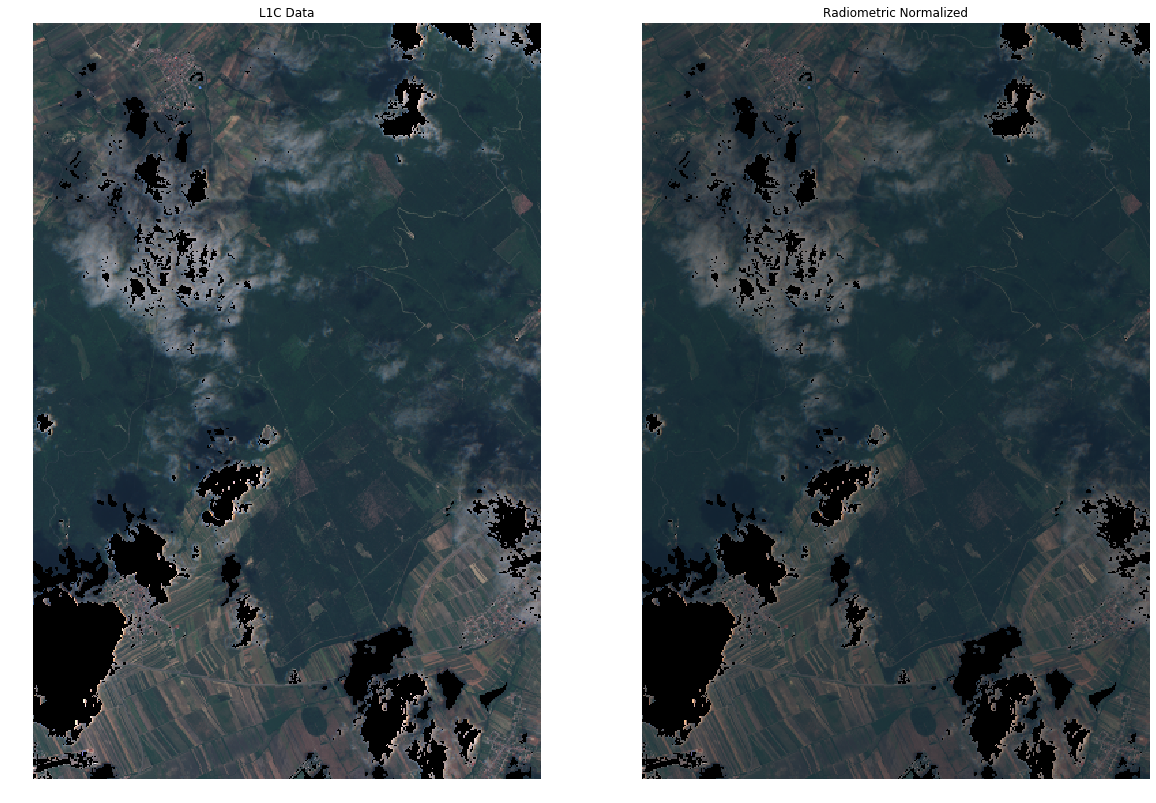

In [19]:
#  Lets plot a subset of the first three bands (RGB) of the nth input scene (left) and output scene (right) as an example

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
axs[0].imshow(2.5*np.flip(example_input_scene[..., 0:3], axis=2))
axs[1].imshow(2.5*np.flip(example_output_scene[..., 0:3], axis=2))
axs[0].set_title("L1C Data")
axs[1].set_title("Radiometric Normalized")
axs[0].set_axis_off()
axs[1].set_axis_off()
plt.show()

### Lets see if an index makes that normalization visible

In contrast to the previously displayed RGB images, an index might be able to show the influence of the radiometric normalization better.  
  
The index Tasseled Cap includes three bands: "brightness", "greenness" and "wetness". The advantage of this index is the consideration of all satellite bands. Similar to the Principle Component Analysis, the most valueable information is kept and summarized while using less data memory.

In [20]:
def tasseled_cap_index_for_sentinel2(bands):
    """
    Contributor: Johannes Schmid, GeoVille Information Systems GmbH, 2018
    Tasseled Cap index adjusted to Sentinel-2 data after
    Nedkov, R. (2017): Orthogonal transformation of segmented images from the satellite Sentinel-2.
    In: Comptes rendus de l'Académie bulgare des sciences 70., p. 687-692.
    The index was renormalized due to the missing bands 1, 9 and 10.
    """
    BLUE = bands[:,:,0]    # B02
    GREEN = bands[:,:,1]   # B03
    RED = bands[:,:,2]     # B04
    RE1 = bands[:,:,3]     # B05
    RE2 = bands[:,:,4]     # B06
    RE3 = bands[:,:,5]     # B07
    NIR = bands[:,:,6]     # B08
    NIR2 = bands[:,:,7]    # B8A
    SWIR1 = bands[:,:,8]   # B11
    SWIR2 = bands[:,:,9]   # B12
    
    brightness = 8.262635e-02 * BLUE + 1.367054e-01 * GREEN + 2.624542e-01 * RED + 2.979373e-01 * RE1 + 3.355313e-01 * RE2 + 3.897109e-01 * RE3 + 3.915202e-01 * NIR + 4.774637e-01 * NIR2 + 3.902135e-01 * SWIR1 + 1.373085e-01 * SWIR2
    greenness = -1.131535e-01 * BLUE + -1.685265e-01 * GREEN + -3.490906e-01 * RED + -3.313352e-01 * RE1 + 8.546702e-02 * RE2 + 3.312349e-01 * RE3 + 3.174919e-01 * NIR + 3.636361e-01 * NIR2 + -4.592348e-01 * SWIR1 + -4.076737e-01 * SWIR2
    wetness = 1.366490e-01 * BLUE + 2.809175e-01 * GREEN + 3.079867e-01 * RED + 5.301541e-01 * RE1 + 1.382531e-01 * RE2 + -1.002561e-04 * RE3 + -8.090665e-02 * NIR + -1.392557e-01 * NIR2 + -4.074407e-01 * SWIR1 + -5.616345e-01 * SWIR2
    
    return np.dstack([brightness, greenness, wetness])

In [21]:
tasseled_cap_input = tasseled_cap_index_for_sentinel2(example_input_scene)
tasseled_cap_output = tasseled_cap_index_for_sentinel2(example_output_scene)

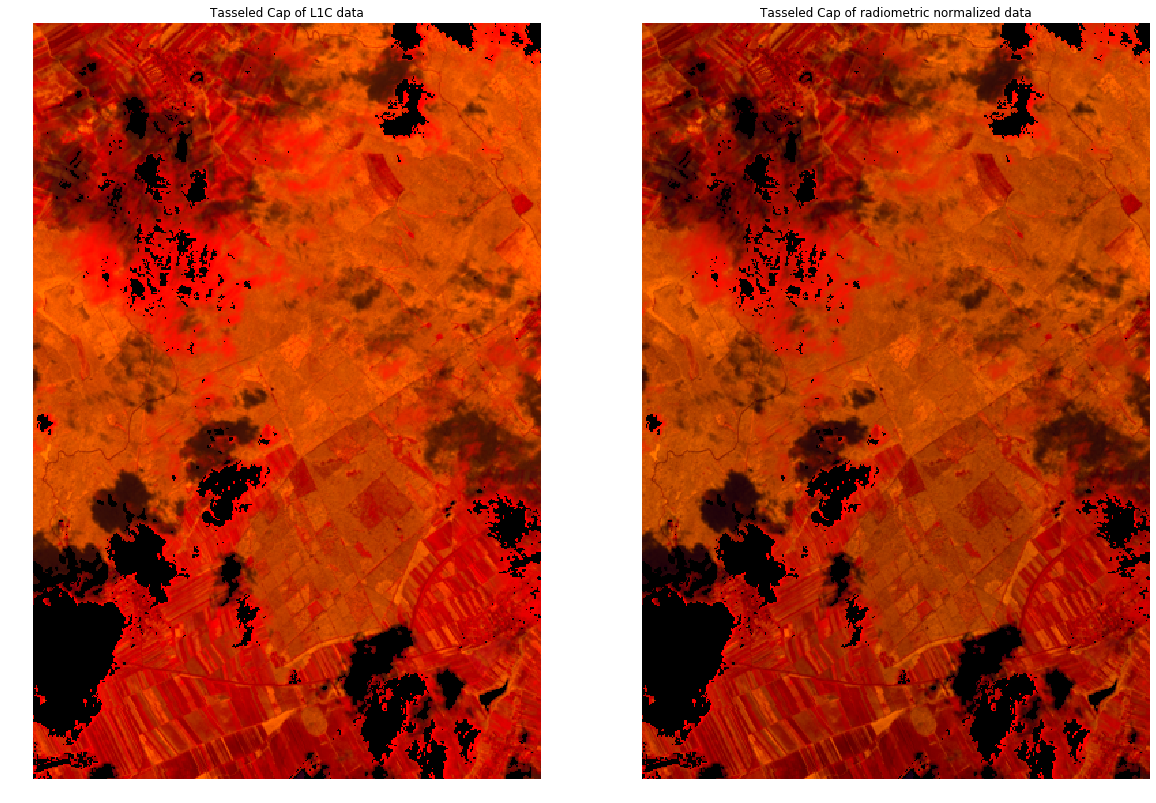

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
axs[0].imshow(tasseled_cap_input[..., :])
axs[1].imshow(tasseled_cap_output[..., :])
axs[0].set_title("Tasseled Cap of L1C data")
axs[1].set_title("Tasseled Cap of radiometric normalized data")
axs[0].set_axis_off()
axs[1].set_axis_off()
plt.show()

By taking a closer look at the histograms of the Tasseled Cap Brightness values with L1C data (left) and radiometric normalized data (right) as the function input, a significant difference can be seen.

/home/devis/anaconda3/envs/review-pr-34/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/devis/anaconda3/envs/review-pr-34/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


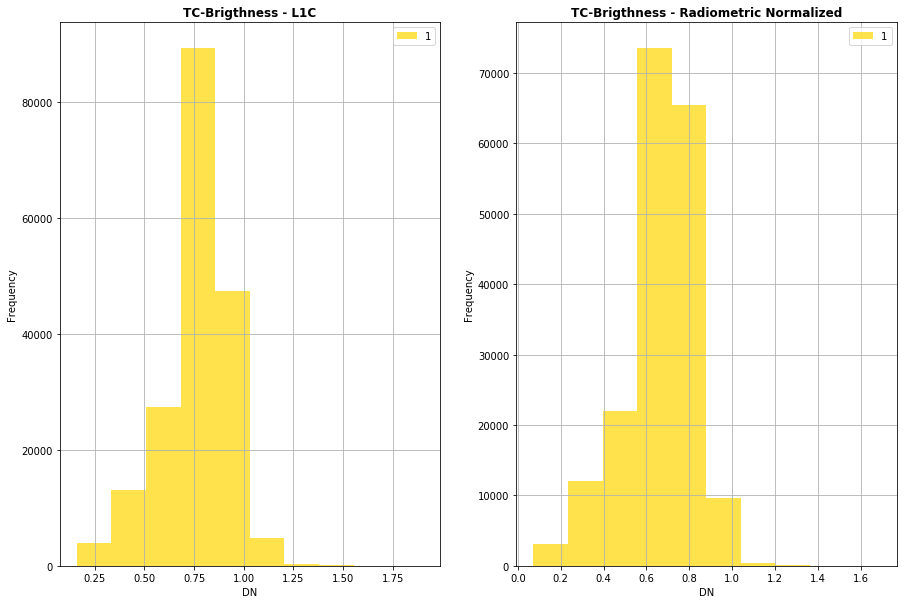

In [23]:
a = tasseled_cap_input[..., 0]
b = tasseled_cap_output[..., 0]

from rasterio.plot import show_hist
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
show_hist(a, ax=axs[0], lw=0.0, stacked=False, alpha=0.7, histtype='stepfilled', title="TC-Brigthness - L1C")
show_hist(b, ax=axs[1], lw=0.0, stacked=False, alpha=0.7, histtype='stepfilled', title="TC-Brigthness - Radiometric Normalized")
plt.show()

Looking at the histogram of the reference composite (figure below), the distribution of the values is highest between 0.5 and 0.7. Thus, the normalization of the L1C data should have a similar value distribution which can be seen above.  Nevertheless, validating the effects of relative radiometric normalization is very challenging and would go beyond the scope of this demonstration.

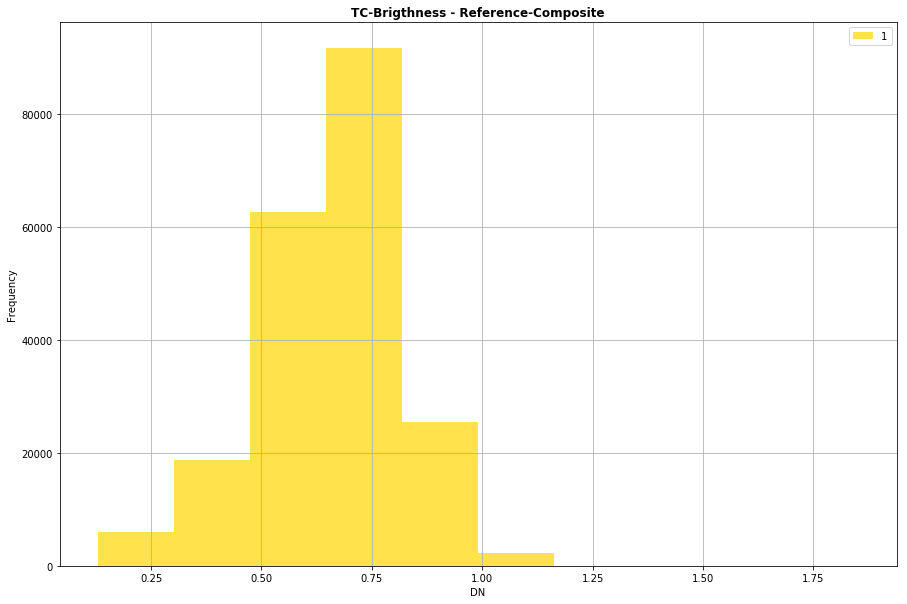

In [24]:
ref_comp = patch.data_timeless["reference_composite"]
ref_comp[ref_comp==-32768] = np.nan
tasseled_cap_reference = tasseled_cap_index_for_sentinel2(ref_comp)

fig, axs = plt.subplots(figsize=(15,10))
show_hist(tasseled_cap_reference[...,0], ax=axs, lw=0.0, stacked=False, alpha=0.7, histtype='stepfilled', title="TC-Brigthness - Reference-Composite")
plt.show()